In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = CIFAR10(root='data02/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data02/', train=False, transform=ToTensor())

Files already downloaded and verified


In [3]:
#Dataset Size
len(dataset)

50000

In [4]:
len(test_dataset)

10000

In [5]:
#Classes
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
#No of Classes
num_classes = len(dataset.classes)
num_classes

10

In [7]:
#Showing the Image shape
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Label (numeric): 6
Label (textual): frog


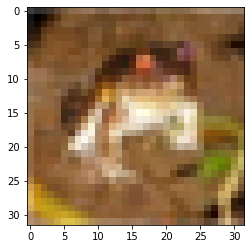

In [8]:
#Showing the image
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [9]:
#Challenge: determine the number of images belonging to each class
##Loop (?)

# Data Prepration for Training

In [10]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [11]:
#Splitting DS in train and val_dataset using random_split
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [12]:
# BATCH Size
batch_size = 128
batch_size

128

In [13]:
#Loading Data using Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size*2, shuffle = True, num_workers = 4, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size*2, shuffle = True, num_workers = 4, pin_memory = True)

images shape :  torch.Size([128, 3, 32, 32])


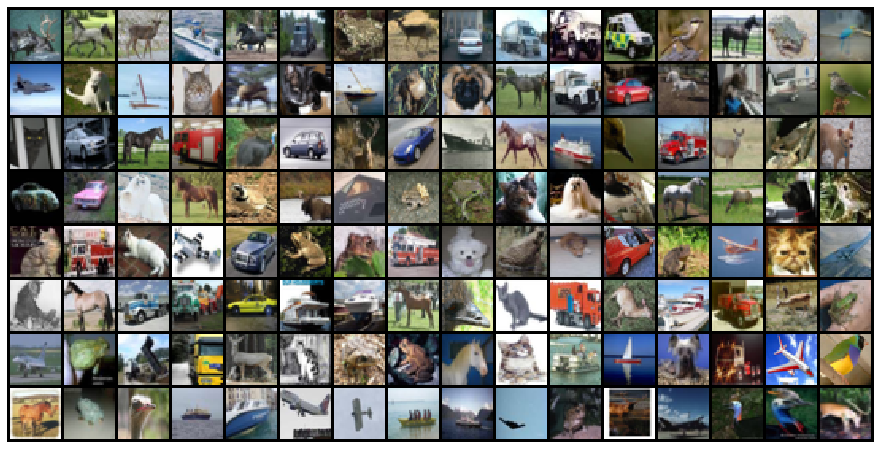

In [14]:
#Visualizing a Batch of Data
for images, _ in train_loader:
    print("images shape : ", images.shape)
    plt.figure(figsize = (16,8))
    plt.axis(('off'))
    plt.imshow(make_grid(images, nrow = 16).permute((1,2,0)))
    break

# Base Model Class and Setting up GPU

In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

In [16]:
"""class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                       #Generate Predictions
        loss = F.cross_entropy(out, labels)     #Calculate Loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, batch):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  #Combine Losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     #Combine Accuracies
        return{'val_loss : ': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, end):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        """
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    

In [17]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Setting up GPU

In [18]:
torch.cuda.is_available()

True

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [24]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# Training the Model

In [52]:
input_size = 3*32*32
output_size = 10
hidden1_size = 256
hidden2_size = 64

In [53]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden1_size)
        self.linear2 = nn.Linear(hidden1_size, hidden2_size)
        self.linear3 = nn.Linear(hidden2_size, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        xb = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(xb)
        out = F.relu(out)
        
        out = self.linear2(out)
        out = F.relu(out)
        
        out = self.linear3(out)
        out = F.relu(out)
        return out

In [54]:
model = to_device(CIFAR10Model(), device)

In [55]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.303903579711914, 'val_acc': 0.0854090079665184}]

In [56]:
history += fit(10, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 2.1015, val_acc: 0.2669
Epoch [1], val_loss: 2.0521, val_acc: 0.2721
Epoch [2], val_loss: 1.7948, val_acc: 0.3614
Epoch [3], val_loss: 1.7274, val_acc: 0.3875
Epoch [4], val_loss: 1.6837, val_acc: 0.3983
Epoch [5], val_loss: 1.6928, val_acc: 0.3883
Epoch [6], val_loss: 1.6941, val_acc: 0.3918
Epoch [7], val_loss: 1.6102, val_acc: 0.4333
Epoch [8], val_loss: 1.5740, val_acc: 0.4441
Epoch [9], val_loss: 1.5500, val_acc: 0.4492


In [57]:
history += fit(10, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4783, val_acc: 0.4802
Epoch [1], val_loss: 1.4854, val_acc: 0.4752
Epoch [2], val_loss: 1.4725, val_acc: 0.4779
Epoch [3], val_loss: 1.4756, val_acc: 0.4784
Epoch [4], val_loss: 1.4649, val_acc: 0.4854
Epoch [5], val_loss: 1.4653, val_acc: 0.4815
Epoch [6], val_loss: 1.4634, val_acc: 0.4839
Epoch [7], val_loss: 1.4561, val_acc: 0.4807
Epoch [8], val_loss: 1.4467, val_acc: 0.4912
Epoch [9], val_loss: 1.4401, val_acc: 0.4909


In [58]:
history += fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4285, val_acc: 0.4950
Epoch [1], val_loss: 1.4283, val_acc: 0.5003
Epoch [2], val_loss: 1.4279, val_acc: 0.4965
Epoch [3], val_loss: 1.4308, val_acc: 0.4960
Epoch [4], val_loss: 1.4258, val_acc: 0.5001
Epoch [5], val_loss: 1.4242, val_acc: 0.5001
Epoch [6], val_loss: 1.4294, val_acc: 0.4974
Epoch [7], val_loss: 1.4293, val_acc: 0.5009
Epoch [8], val_loss: 1.4279, val_acc: 0.4991
Epoch [9], val_loss: 1.4203, val_acc: 0.5013


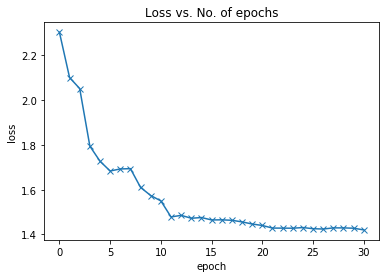

In [59]:
plot_losses(history)

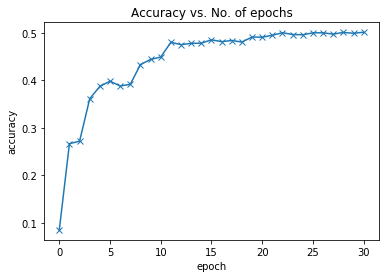

In [60]:
plot_accuracies(history)

In [61]:
evaluate(model, test_loader)

{'val_loss': 1.3879226446151733, 'val_acc': 0.5116211175918579}

In [62]:
torch.save(model.state_dict(), 'cifar10-feedforward.pth')